In [73]:
import matplotlib.pyplot as plt

import numpy as np

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import winsound

from scipy.spatial import Delaunay
import scipy.linalg

from DDV import eigenbasis


In [2]:
n_grid = 10
extent = 1

grid = np.meshgrid(np.linspace(-extent, extent, n_grid), np.linspace(-extent, extent, n_grid))
grid_points = (np.column_stack([grid[0].ravel(), grid[1].ravel()]))

triangulation = Delaunay(grid_points)

eigenvalues, d_vert_vecs, c_vert_vecs, vol, complex = eigenbasis.generate_vector_basis(triangulation.points, triangulation.simplices, flat=True, depth=(n_grid**2)-2)

C:\Users\mg874\anaconda3\Lib\site-packages\pydec\dec\simplicial_complex.py:177: RuntimeWarning: divide by zero encountered in divide
  data.star_inv = sparse.spdiags([1.0/stardiag],[0], N, N, format='csr')
Processing eigenvectors:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [24]:
scalar_L = complex[0].d.T @ complex[1].star @ complex[0].d
_, basis_eigenvectors = jnp.linalg.eigh(scalar_L.todense())

In [261]:
def matern_scaling(l, k, v, dim):
    if v == jnp.inf:
        return jnp.exp(-((k ** 2) / 2.) * l)
    else:
        return jnp.power(((2 * v) / (k ** 2)) + l, - v - (dim / 2.))


def matern_scaling_ns(l, k, v, dim):
    if v == jnp.inf:
        return jnp.exp(-((k ** 2) / 2.) * l)
    else:
        return jnp.power(((2 * v) / (k[:, None].T ** 2)) + l[:, None], - v - (dim / 2.))


def sample_vector_field_ns(eigenvalues, d_eigenfields, c_eigenfields, dim, vol, kappa_d, kappa_c, params):
    # kappa has a value at every grid point, shape: [N,]
    
    ms_d = matern_scaling_ns(eigenvalues, kappa_d, params["v"], dim)
    ms_c = matern_scaling_ns(eigenvalues, kappa_c, params["v"], dim)

    ms_d = ms_d / np.sqrt(eigenvalues[:, None])
    ms_c = ms_c / np.sqrt(eigenvalues[:, None])

    vs_d = np.zeros((len(d_eigenfields), len(d_eigenfields[1])))
    vs_c = np.zeros((len(c_eigenfields), len(c_eigenfields[1])))
    for i in range(1, len(ms_d)):
        vs_d = vs_d + np.diag(np.sqrt(ms_d[i])) @ np.array(d_eigenfields[:, :, i]) * np.random.normal(0, 1, 1) 
        vs_c = vs_c + np.diag(np.sqrt(ms_c[i])) @ np.array(c_eigenfields[:, :, i]) * np.random.normal(0, 1, 1) 

    c_d = np.sum(np.mean(ms_d, axis=1)) / vol
    c_c = np.sum(np.mean(ms_c, axis=1)) / vol
    
    
    vs_d = vs_d * params["s_d"] / np.sqrt(c_d)
    vs_c = vs_c * params["s_c"] / np.sqrt(c_c)

    result = vs_d + vs_c

    return result

In [262]:
def vector_mesh_kernel_ns(eigenvalues, d_eigenfields, c_eigenfields, points_1, points_2, dim, vol, kappa_d, kappa_c, params):
    eigenvalues = jnp.array(eigenvalues)

    d_eigenfields = jnp.array(d_eigenfields)
    c_eigenfields = jnp.array(c_eigenfields)

    kappa_d = jnp.array(kappa_d)
    kappa_c = jnp.array(kappa_c)
    
    points_1 = jnp.array(points_1)
    points_2 = jnp.array(points_2)


    ms_d = matern_scaling_ns(eigenvalues, kappa_d, params["v"], dim)
    ms_c = matern_scaling_ns(eigenvalues, kappa_c, params["v"], dim)

    ms_d = ms_d / jnp.sqrt(eigenvalues[:, jnp.newaxis])
    ms_c = ms_c / jnp.sqrt(eigenvalues[:, jnp.newaxis])

    # Subset the points of the eigenfields that you are interested in.
    d_fields_1 = jnp.multiply(d_eigenfields[points_1], jnp.expand_dims(jnp.sqrt(ms_d.T[points_1]), 1))
    d_fields_2 = jnp.multiply(d_eigenfields[points_2], jnp.expand_dims(jnp.sqrt(ms_d.T[points_2]), 1))
    c_fields_1 = jnp.multiply(c_eigenfields[points_1], jnp.expand_dims(jnp.sqrt(ms_c.T[points_1]), 1))
    c_fields_2 = jnp.multiply(c_eigenfields[points_2], jnp.expand_dims(jnp.sqrt(ms_c.T[points_2]), 1))

    K_d = jnp.einsum('ijm,klm->ikjl', d_fields_1, d_fields_2)
    K_c = jnp.einsum('ijm,klm->ikjl', c_fields_1, c_fields_2)

    K_d = K_d.transpose((0, 2, 1, 3)).reshape((len(points_1) * dim, len(points_2) * dim))
    K_c = K_c.transpose((0, 2, 1, 3)).reshape((len(points_1) * dim, len(points_2) * dim))

    # Compute scaling coefficients
    c_d = jnp.sum(jnp.mean(ms_d, axis=1)) / vol
    c_c = jnp.sum(jnp.mean(ms_c, axis=1)) / vol
    
    # Final kernel with variance scaling
    K = ((params["s_d"] ** 2) / c_d) * K_d + ((params["s_c"] ** 2) / c_c) * K_c
    return K

In [347]:
n_points = grid_points.shape[0]
prior_length_scale = extent*2/3
prior_variance = 2

def rbf_kernel(X1, X2, length_scale, variance):
    """Compute RBF kernel matrix between two sets of points."""
    sq_dist = scipy.spatial.distance.cdist(X1, X2, 'sqeuclidean')
    return variance * np.exp(-0.5 * sq_dist / length_scale**2)

# Prior covariance for w1 and w2 (same hyperparameters)
K_prior = rbf_kernel(grid_points, grid_points,
                     prior_length_scale, prior_variance) + 1e-6 * np.eye(n_points)

# Cholesky decomposition for MVN sampling
L_prior = np.linalg.cholesky(K_prior)

In [377]:
z1 = np.random.randn(n_points)
z2 = np.random.randn(n_points)

kappa_d_true_log = (L_prior @ z1)
kappa_c_true_log = (L_prior @ z2)


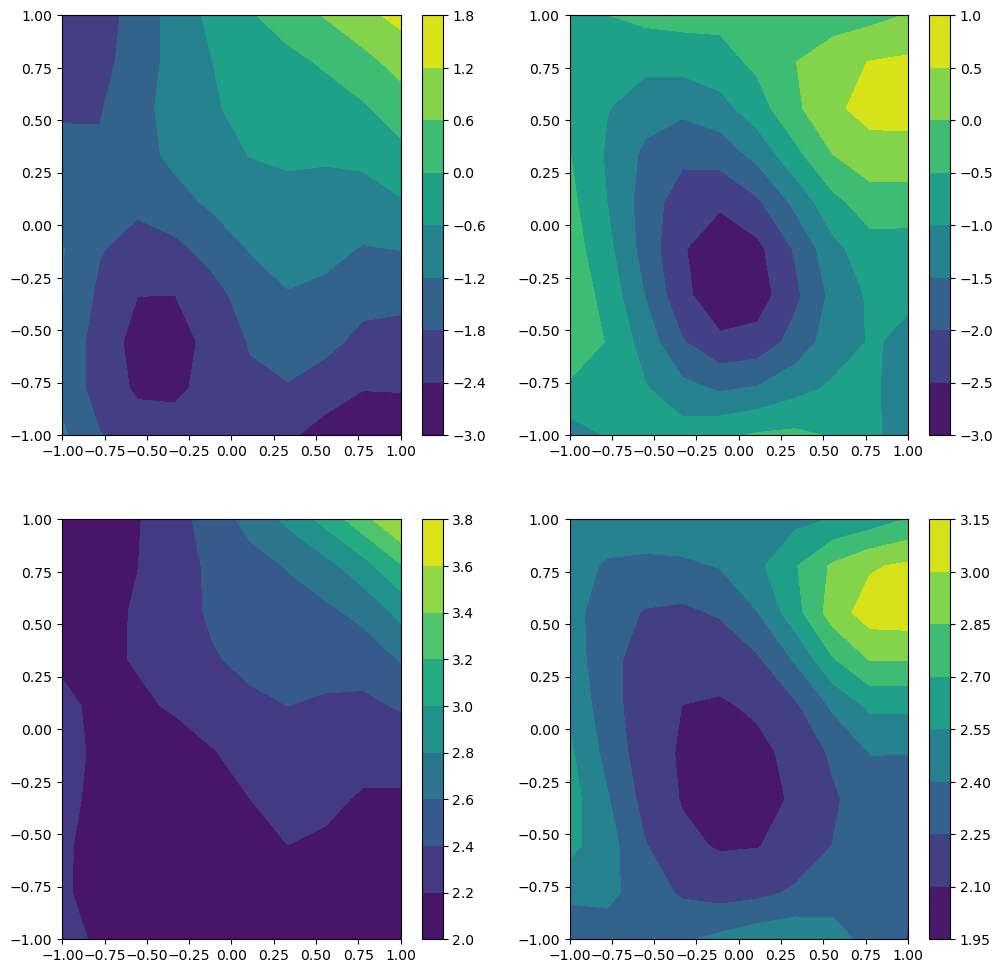

In [378]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

xi, yi = grid

z1_true = scipy.interpolate.griddata(grid_points, kappa_d_true_log, (xi, yi), method='linear')
z2_true = scipy.interpolate.griddata(grid_points, kappa_c_true_log, (xi, yi), method='linear')

cf1 = axs[0, 0].contourf(xi, yi, z1_true)
plt.colorbar(cf1, ax=axs[0, 0])
cf2 = axs[0, 1].contourf(xi, yi, z2_true)
plt.colorbar(cf2, ax=axs[0, 1])

cf3 = axs[1, 0].contourf(xi, yi, jax.nn.softplus(z1_true) + 2.0)
plt.colorbar(cf3, ax=axs[1, 0])
cf4 = axs[1, 1].contourf(xi, yi, jax.nn.softplus(z2_true) + 2.0)
plt.colorbar(cf4, ax=axs[1, 1])


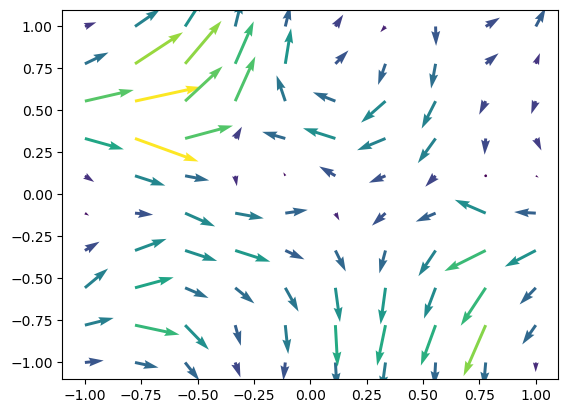

In [379]:
params = {
    "s_d": 1,
    "s_c": 3,
    "v": 1.5
}

# kappa_d_true = jax.nn.softplus(kappa_d_true_log + 5)
# kappa_c_true = jax.nn.softplus(kappa_c_true_log + 5)


kappa_d_true = jax.nn.softplus(kappa_d_true_log) + 2.0
kappa_c_true = jax.nn.softplus(kappa_c_true_log) + 2.0

samp = sample_vector_field_ns(eigenvalues[1:], d_vert_vecs[:, :, 1:], c_vert_vecs[:, :, 1:], 2, vol, kappa_d_true, kappa_c_true, params)

# noise_std = 0.5
vecs = samp #+ noise_std * np.random.randn(*samp.shape)

plt.quiver(grid_points[:, 0], grid_points[:, 1], vecs[:, 0], vecs[:, 1], np.linalg.norm(vecs, axis=1))

In [380]:
num_samples = 2500

samples = np.zeros((num_samples, *samp.shape))

for i in range(num_samples):
    sample = sample_vector_field_ns(eigenvalues[1:], d_vert_vecs[:, :, 1:], c_vert_vecs[:, :, 1:], 2, vol, kappa_d_true, kappa_c_true, params)
    sample_norm = jnp.mean(jnp.linalg.norm(sample, axis=1))
    samples[i, :, :] = sample / sample_norm
    
vec_samples = samples.reshape(num_samples, n_points * 2)

In [381]:
import jax.debug
jax.config.update("jax_enable_x64", True)

M = 20
phi_basis = basis_eigenvectors[:, :M]

def nonstationary_model(Y):
    """
    Bayesian model for anisotropic kernel inference.
    
    Args:
        Y: Data array of shape (n_realizations, n_points * 2)
    """
    
    weights_d = numpyro.sample("weights_d", dist.Normal(0.0, 1.0).expand([M]))
    weights_c = numpyro.sample("weights_c", dist.Normal(0.0, 1.0).expand([M]))

    kappa_d = jax.nn.softplus(jnp.dot(phi_basis, weights_d)) + 2.0
    kappa_c = jax.nn.softplus(jnp.dot(phi_basis, weights_c)) + 2.0

    # Construct kernel from current parameters
    kernel = vector_mesh_kernel_ns(jnp.array(eigenvalues[1:]), d_vert_vecs[:, :, 1:], c_vert_vecs[:, :, 1:], range(n_points), range(n_points), 2, vol, kappa_d, kappa_c, params) + 1e-4 * jnp.eye(n_points * 2)


    #### debug stuff
    # jax.debug.print("Symmetry error: {}", jnp.max(jnp.abs(kernel - kernel.T)))
    # 
    # eigvals = jnp.linalg.eigvalsh(kernel)
    # jax.debug.print("Smallest eigenvalue: {}", eigvals.min())
    # 
    # jax.debug.print("Any NaNs? {}", jnp.isnan(kernel).any())
    # jax.debug.print("Any Infs? {}", jnp.isinf(kernel).any())
    # 
    # svd = jnp.linalg.svd(kernel, compute_uv=False)
    # jax.debug.print("Condition number: {}", svd[0] / svd[-1])


    # Data likelihood for each realization
    with numpyro.plate("realizations", Y.shape[0]):
        numpyro.sample(
            "obs",
            dist.MultivariateNormal(
                loc=np.zeros(n_points * 2),
                covariance_matrix=kernel,
                validate_args=True
            ),
            obs=Y
        )

In [385]:
from numpyro.handlers import seed, trace

tr = trace(seed(nonstationary_model, jax.random.PRNGKey(0))).get_trace(Y=vec_samples)
for name, site in tr.items():
    print(f"{name}: {site['value'].shape}")
    

weights_d: (20,)
weights_c: (20,)
realizations: (2500,)
obs: (2500, 200)


In [386]:
nuts_kernel = NUTS(nonstationary_model,
                   max_tree_depth=12,
                   adapt_step_size=True,
                   adapt_mass_matrix=True)

# Run MCMC
mcmc = MCMC(nuts_kernel,
            num_warmup=200,
            num_samples=500)

mcmc.run(jax.random.PRNGKey(0), Y=vec_samples)

# Get posterior samples
summary_dict = numpyro.diagnostics.summary(mcmc.get_samples(), group_by_chain=False)

# print the largest r_hat for each variable
for k, v in summary_dict.items():
    spaces = " " * max(12 - len(k), 0)
    print("[{}] {} \t max r_hat: {:.4f}".format(k, spaces, np.max(v["r_hat"])))

winsound.Beep(440, 1000)

warmup:   5%|▍         | 33/700 [00:17<05:51,  1.90it/s, 7 steps of size 2.58e-03. acc. prob=0.71]  


KeyboardInterrupt: 

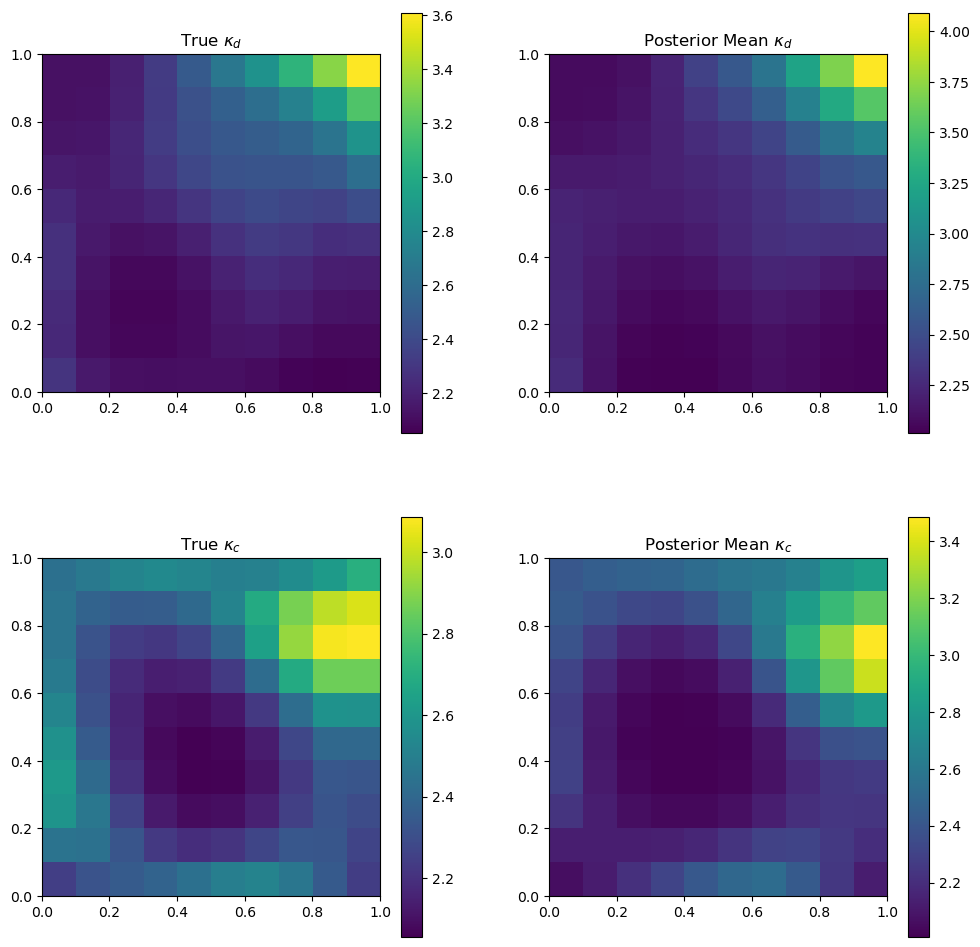

In [384]:
weights_d_post_mean = summary_dict["weights_d"]['mean']
weights_c_post_mean = summary_dict["weights_c"]['mean']

kd_post_mean = jax.nn.softplus(jnp.dot(phi_basis, weights_d_post_mean)) + 2
# kd_post_std = summary_dict["kappa_d"]['std']
kc_post_mean = jax.nn.softplus(jnp.dot(phi_basis, weights_c_post_mean)) + 2
# kc_post_std = summary_dict["kappa_c"]['std']


fig, axs = plt.subplots(2, 2, figsize=(12, 12))

cf1 = axs[0, 0].imshow(kappa_d_true.reshape((n_grid, n_grid)),
                        extent=[0, 1, 0, 1],
                        origin="lower")
axs[0, 0].title.set_text("True $\kappa_d$")
plt.colorbar(cf1, ax=axs[0, 0])

cf2 = axs[0, 1].imshow(kd_post_mean.reshape((n_grid, n_grid)),
                       extent=[0, 1, 0, 1],
                       origin="lower")
axs[0, 1].title.set_text("Posterior Mean $\kappa_d$")
plt.colorbar(cf2, ax=axs[0, 1])

cf3 = axs[1, 0].imshow(kappa_c_true.reshape((n_grid, n_grid)),
                       extent=[0, 1, 0, 1],
                       origin="lower")
axs[1, 0].title.set_text("True $\kappa_c$")
plt.colorbar(cf3, ax=axs[1, 0])

cf4 = axs[1, 1].imshow(kc_post_mean.reshape((n_grid, n_grid)),
                       extent=[0, 1, 0, 1],
                       origin="lower")
axs[1, 1].title.set_text("Posterior Mean $\kappa_c$")
plt.colorbar(cf4, ax=axs[1, 1])

